## LOAD LIBRARIES

In [23]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import json
import requests
import io

import warnings
warnings.simplefilter('ignore')

from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import accuracy_score

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier

from sklearn.model_selection import GridSearchCV

from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical

from IPython.display import display, HTML, Image

# 4.0. Modeling 

The modeling in this Notebook mirrors what we performed in our later assignments, involving many classes of models. 

- This Notebook presents the second NLP analysis that was conducted by hand using the NLTK library.
- Different than Notebook 4, all the modeling performed in this Notebook does not aggregate data by Twitter user. 

## NLP

In [25]:
print("Loading  Data")
# try to load files locally, if don't exist, we load try to load from Microsoft Azure. 
#We could not upload to Github.com because we are using a private repository and the files were to large.

try:
    with open("data/final_tweets_master_withNLP.json") as datafile:
        data = json.load(datafile)

    text_data = pd.read_json(data)
except Exception as e:
    print("Loading data from Azure - data files do not exist locally")
    data_url = "https://eumarharvardfiles.blob.core.windows.net/cscis109/final_tweets_master_withNLP.json"
    data_content = requests.get(data_url).content

    text_data = pd.read_json(json.load(io.StringIO(data_content.decode('utf-8'))))
    
    
text_data.shape

Loading  Data
Loading Data from Azure - does not exist locally


(51106, 30)

In [26]:
print("\nLet's investigate how many are bots (True) and how many aren't (False):\n")
print(text_data.groupby('known_bot').count()['TypeOfUser'])


Let's investigate how many are bots (True) and how many aren't (False):

known_bot
False     8203
True     42903
Name: TypeOfUser, dtype: int64


In [27]:
print("\nNext we'll polish the dataframe by removing NAs (might not be necessary).\n")
from nltk.tokenize import TweetTokenizer
tt = TweetTokenizer()

print("Original, non-retweeted count of bot tweets: {}.".format(len(text_data)))
text_data.dropna(subset=['text'], inplace=True)
print("Count after removing empty tweets: {}.\n".format(len(text_data)))


useful_cols = ['followers_count','known_bot','text','tokens','name',
               'nlp_key_phrases','nlp_sentiment_score','nlp_count_key_phrases','is_tweet', 'tweet_length']
text_data['tokens'] = text_data['text'].apply(tt.tokenize)

text_data['tweet_length'] = text_data['tokens'].str.len()

bot_texts = text_data.loc[text_data.known_bot == True][useful_cols]
real_texts= text_data.loc[text_data.known_bot == False][useful_cols]


Next we'll polish the dataframe by removing NAs (might not be necessary).

Original, non-retweeted count of bot tweets: 51106.
Count after removing empty tweets: 50757.




Let's look at the distribution of tweet lengths by bot vs tweet lengths by real people. We achieve this by tokenizing the tweet sentences with the NLTK package (natural language processing library).Next we group by name and find the mean tweet length by user name.



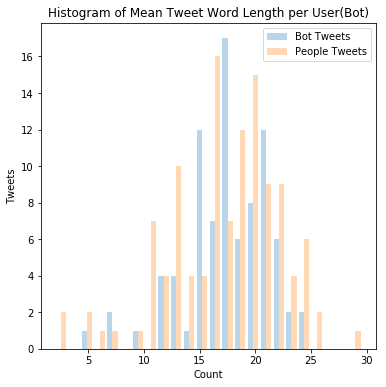

In [5]:
print("\nLet's look at the distribution of tweet lengths by bot vs tweet lengths by real people. \
We achieve this by tokenizing the tweet sentences with the NLTK package (natural language processing library).\
Next we group by name and find the mean tweet length by user name.\n")
tweet_len_by_bot = bot_texts.groupby(['name']).tweet_length.mean().sort_values(ascending=False)
tweet_len_by_usr = real_texts.groupby(['name']).tweet_length.mean().sort_values(ascending=False)


fig, ax = plt.subplots(1,1, figsize= (6,6))
ax.hist([tweet_len_by_bot,tweet_len_by_usr], bins = int(max(tweet_len_by_bot)), 
        label=["Bot Tweets","People Tweets"], alpha=0.3)
ax.set_title("Histogram of Mean Tweet Word Length per User(Bot)")
ax.set_ylabel("Tweets")
ax.set_xlabel("Count")
ax.legend()

In [28]:
print("\nThere's no real pattern shown there, but let's take one more look by box plotting:\n")
plt.boxplot ([tweet_len_by_bot, tweet_len_by_usr], labels=['Bot','Person'])
plt.ylabel("Average tweet lengths")
plt.title("Average Tweet Lengths by Type of User")


There's no real pattern shown there, but let's take one more look by box plotting:



NameError: name 'tweet_len_by_bot' is not defined

In [7]:
print("\nAbove we can see that there's more variability in real people's sentences; this means people are \
having short and long conversations with huge variability in the length of their tweets. Bots however are having \
much more consice conversations of which 75% are 16-20 word length. Real people have 13-23 words in their tweets, \
on average.\n")
print("\nThis is an excellent place to begin classification but it's only one parameter. Let's construct\
 a much richer series of parameters on which to perform classification based on vocabulary. \n\
Next we shall investigate all of their tweets as one big bundle, and look at the vocabulary choices across several \
tweets. To begin, we shall aggregate by name and add the tokenized tweets to one big list.\n")
import nltk
from nltk import FreqDist
from nltk.corpus import stopwords
import string

# Actual NLP stuff. 
bot_words = bot_texts.groupby(['name']).tokens.agg(sum)
usr_words = real_texts.groupby(['name']).tokens.agg(sum)


Above we can see that there's more variability in real people's sentences; this means people are having short and long conversations with huge variability in the length of their tweets. Bots however are having much more consice conversations of which 75% are 16-20 word length. Real people have 13-23 words in their tweets, on average.


This is an excellent place to begin classification but it's only one parameter. Let's construct a much richer series of parameters on which to perform classification based on vocabulary. 
Next we shall investigate all of their tweets as one big bundle, and look at the vocabulary choices across several tweets. To begin, we shall aggregate by name and add the tokenized tweets to one big list.



In [ ]:
print("\nThe next really important step is to remove all of the stop words. Stop words are \
essentially useless words that don't add value to sentiment analysis, such as 'the' or 'of'.\n")
bot_words = pd.DataFrame(bot_words)
usr_words = pd.DataFrame(usr_words)

bot_words.columns = ['words']
usr_words.columns = ['words']

stop_words  = stopwords.words('english') + list(string.punctuation) + [' ','rt',"\'", "...", "..","`",'\"', '–', '’', "I'm", '…','""','“','”']

# Construct list of cleaned words
usr_words['cleaned_words'] = [[word for word in words if word.lower() not in stop_words] 
                                for words in usr_words['words']]
bot_words['cleaned_words'] = [[word for word in words if word.lower() not in stop_words] 
                              for words in bot_words['words']]

In [9]:
# Get the frequencies
print("\nNext we'll get the counts and the frequencies of the words used. We'll also pull out the most used words\
by both groups to investigate what is going on in their respective tweets.\n")
freq_per_usr = FreqDist(list([a for b in usr_words.cleaned_words.tolist() for a in b]))
freq_per_bot = FreqDist(list([a for b in bot_words.cleaned_words.tolist() for a in b]))

# Most common words
common_words_bot = pd.DataFrame(freq_per_bot.most_common())
common_words_usr = pd.DataFrame(freq_per_usr.most_common())

cols = ["Words", "Count"]
common_words_bot.columns = cols
common_words_usr.columns = cols

common_words_usr['Frequency'] = common_words_usr['Count']/len(common_words_usr)
common_words_bot['Frequency'] = common_words_bot['Count']/len(common_words_bot)


Next we'll get the counts and the frequencies of the words used. We'll also pull out the most used wordsby both groups to investigate what is going on in their respective tweets.



In [29]:
print("The following calculation was conducted on words greater than two letters. This removes silly 1-emoji \
tweets and the such.\n")

filter1 = (common_words_usr['Words'].str.len()>=3)
filter2 = (common_words_bot['Words'].str.len()>=3)


filtered_usr = common_words_usr.loc[filter1]
filtered_bot = common_words_bot.loc[filter2]

print("\nThe top 15 words used in real tweets (out of {} unique words)::\n".format(len(filtered_usr)))
print(filtered_usr[:15])
print("\nThe top 15 word used by all bots (out of {} unique words):\n".format(len(filtered_bot)))
print(filtered_bot[:15])

The following calculation was conducted on words greater than two letters. This removes silly 1-emoji tweets and the such.



NameError: name 'common_words_usr' is not defined

In [11]:
print("\nIt appears bots were over 10x more likely to be mentioning Trump - and making any references to politics.\
For instance, real people aren't talking about clinton, obama, and throwing http links.\n")

print("The plan now is to score users based on the top 10 words from the known bots. \
We'll assign one point to the user in the bot-word column every time the bot-word is used. \
First we'll declare the column names and set them to 0\
as default. This makes sense, because it should stay 0 if these topics aren't mentioned.\n")

naughty_words = filtered_bot[:10]

# Set these to 0
for word in naughty_words['Words']:
    text_data[word] = 0


It appears bots were over 10x more likely to be mentioning Trump - and making any references to politics.For instance, real people aren't talking about clinton, obama, and throwing http links.

The plan now is to score users based on the top 10 words from the known bots. We'll assign one point to the user in the bot-word column every time the bot-word is used. First we'll declare the column names and set them to 0as default. This makes sense, because it should stay 0 if these topics aren't mentioned.



In [30]:
print("\nTwo steps in one: Aggregate all of the tweets with a groupby statement, \
then count the total number of instances of these words in each tokenenized tweet collection.\n")

for word in naughty_words['Words']:
    text_data[word] = text_data.apply(lambda row: row['tokens'].count(word), axis=1)


Two steps in one: Aggregate all of the tweets with a groupby statement, then count the total number of instances of these words in each tokenenized tweet collection.



NameError: name 'naughty_words' is not defined

In [13]:
# Now we merge the known bot status back in!
print("\nLet's make sure the tweet names are unique and the if-bot status remains:\n")
text_by_names = text_data.groupby(['name']).sum()[naughty_words['Words']]
to_join = text_data[['name','known_bot']].drop_duplicates().set_index('name')
text_by_names=text_by_names.join(to_join, how='inner').drop_duplicates()

print(text_by_names.head())


Let's make sure the tweet names are unique and the if-bot status remains:

               Trump  Clinton  Hillary  Obama  people  https  like  Donald  \
name                                                                         
1-800-WOKE-AF     72        9        8     39      41      4    20      49   
19:37              4        1        0      1       0      0     1       0   
Abigail Oduro      0        0        0      0       0      0     0       0   
Abigail Silk       7        1        1      0       0      0     1       2   
Addis  Gebre      13        0        1      2       3      0     0       1   

               @blicqer  via  known_bot  
name                                     
1-800-WOKE-AF         0    0       True  
19:37                 0    1       True  
Abigail Oduro         0    0      False  
Abigail Silk          0    0       True  
Addis  Gebre          0    0      False  


In [31]:
# Segregate these again, and join with their respective tweet lengths.
# We want to see how often these tweeters use this particular vocabulary, so we have to rejoin tweet_len_by_xxx to find
#   every person's unique text lengths

bot_texts2 = text_by_names.loc[text_by_names.known_bot == True].join(tweet_len_by_bot, how='inner')
usr_texts2= text_by_names.loc[text_by_names.known_bot == False].join(tweet_len_by_usr, how='inner')

tweet_len_by_bot = pd.DataFrame(tweet_len_by_bot)
tweet_len_by_usr = pd.DataFrame(tweet_len_by_usr)

tweet_len_by_bot.columns = ['mean_tweet_length']
tweet_len_by_usr.columns = ['mean_tweet_length']


fig, ax = plt.subplots(2,5, figsize= (20,8))
ax = ax.ravel()

for i, word in enumerate(naughty_words['Words']):
    ax[i].hist([bot_texts2[word],
                usr_texts2[word]], 
               label=["Bot","Real"])
    ax[i].set_title(word)
    ax[i].set_ylabel('# of Times Word Used')
    ax[i].set_xlabel("# of Accounts")

fig.legend()
plt.tight_layout()

print("\nThe figures below highlight the total number of times any account would mention any of these \
known botty words. \
What we relly want to know are the frequencies on a scale relative to their respective to the sample\
 sizes of the bot-non bot groups, to account for the difference in total sample count across the two groups.\n")
print("This figure is difficult to read; most of the posters never mention these key words. Let's consider another \
approach!\n")

NameError: name 'text_by_names' is not defined

Let's look at their decision to use these words as a ratio to all of the words they typically use. In other words, we shall take a ratio of the key-word count (ie Trump) to mean tweet length for these particular users. We are expecting bots to use these words way more frequently than the average person.



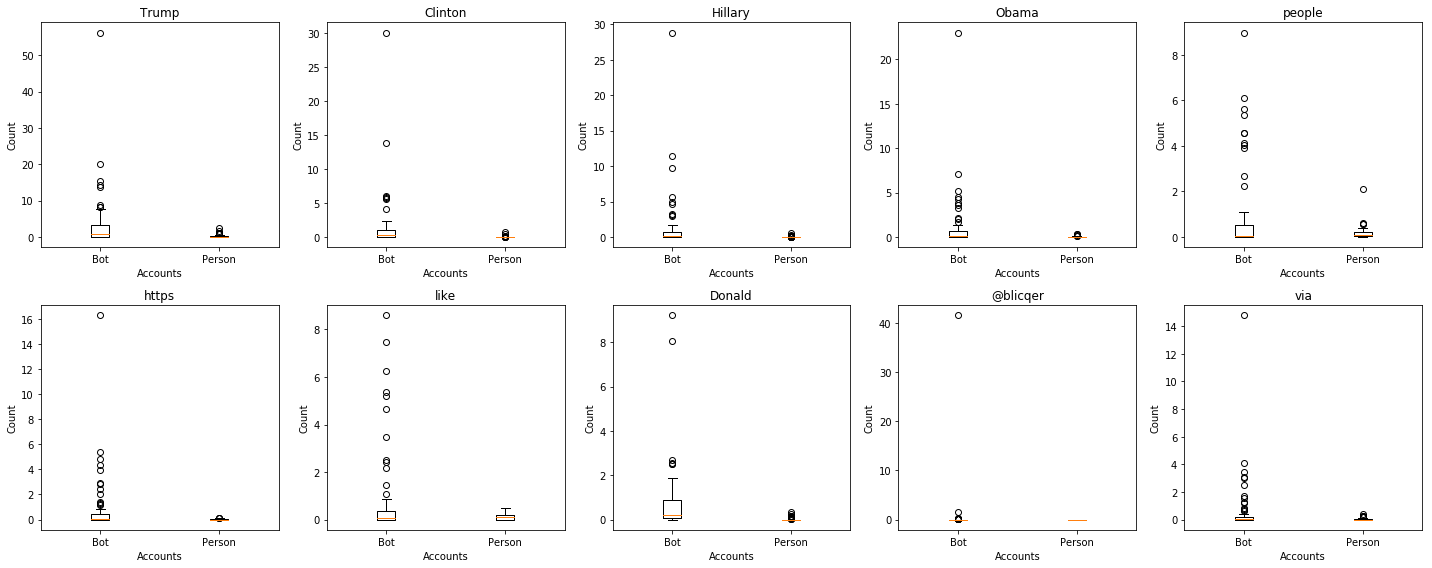

In [15]:
print("Let's look at their decision to use these words as a ratio to all of the words they typically use. \
In other words, we shall take a ratio of the key-word count (ie Trump) to mean tweet length for \
these particular users. We are expecting bots to use these words way more frequently than the average person.\n")
usr_texts2 = usr_texts2.join(tweet_len_by_usr)
bot_texts2 = bot_texts2.join(tweet_len_by_bot)

for word in naughty_words['Words']:
    usr_texts2[word+"_freq"] = usr_texts2[word]/usr_texts2['mean_tweet_length']
    bot_texts2[word+"_freq"] = bot_texts2[word]/bot_texts2['mean_tweet_length']


fig, ax = plt.subplots(2,5, figsize= (20,8))
ax = ax.ravel()

for i, word in enumerate(naughty_words['Words']):
    ax[i].boxplot([bot_texts2[word+"_freq"],
                usr_texts2[word+"_freq"]], labels = ['Bot', 'Person'])
    ax[i].set_title(word)
    ax[i].set_ylabel('Count')
    ax[i].set_xlabel("Accounts")
plt.tight_layout()


We're observing that our bots have a very narrow vocabulary range per tweet, compared to our real people counterparts. The real people mention these key words much less frequently than the bots. This looks like a good place to start applying classification methodologies. We'll use begin by using PCA, and chasing it up with logistic regression.

In [34]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

cols = list(naughty_words['Words']+"_freq")
cols.append("known_bot")
cols.append('mean_tweet_length')

all_res = bot_texts2.append(usr_texts2)
all_res = all_res[cols]

X_train, X_test = train_test_split(all_res, test_size=.2, stratify=all_res['known_bot'])

y_train = X_train['known_bot']*1
y_test = X_test['known_bot']*1

cols = list(naughty_words['Words']+"_freq")
cols.append("mean_tweet_length")

X_train = X_train.drop('known_bot', axis=1)
X_test = X_test.drop('known_bot', axis=1)

scaler = MinMaxScaler().fit(X_train)
X_train = pd.DataFrame(scaler.transform(X_train))
X_test = pd.DataFrame(scaler.transform(X_test))


X_train.columns = cols
X_test.columns = cols

NameError: name 'naughty_words' is not defined

In [33]:
# Let's do some PCA and see if we can distinguish bots from non-bots easily.
from sklearn.decomposition import PCA

pca_transformer = PCA(2).fit(X_train)
cols_pca = ['var1', 'var2']

x_train_2d = pd.DataFrame(pca_transformer.transform(X_train))
x_test_2d = pd.DataFrame(pca_transformer.transform(X_test))

x_train_2d.columns = cols_pca
x_test_2d.columns = cols_pca

user_types = ['Real', 'Bot']
colors = ['b','r']

for user_type in y_train.unique():
    rows = y_train == user_type
    usr_df = x_train_2d.iloc[rows.values,:]
    label = user_types[user_type]
    plt.scatter(usr_df.var1, usr_df.var2, c = colors[user_type], label=label, alpha = 0.3)
    
# all plots need labels
plt.title("PCA Results")
plt.xlabel("PCA Dimension 1")
plt.ylabel("PCA Dimention 2")
plt.legend();

NameError: name 'X_train' is not defined

In [35]:
print("\nBut what are we seeing?\n")
# Dump components relations with features:
pca_df=pd.DataFrame(pca_transformer.components_, columns=cols,index = ['PC-1','PC-2'])
print("\n-----")
print(pca_df)
print("\n-----")
pc1 = pca_df.loc['PC-1'].abs().max()
pc2 = pca_df.loc['PC-2'].abs().max()

print("\nThe goal here is to look for the largest absolute values for PC-1 and PC-2.\n")
print("Maximum PC-1: {:0.3f}, for the {} variable.".format(pc1,pca_df.columns[pca_df.loc['PC-1'].abs() == pc1][0]))
print("Maximum PC-2: {:0.3f}, for the {} variable.".format(pc2,pca_df.columns[pca_df.loc['PC-2'].abs() == pc2][0]))

print("\nIt seems like our original 'tweet word-count' analysis had predictive power! Although PCA doesn't \
appear to be a powerful classifier alone, judging by the plot, it was able to find two potentially \
powerful variables: the tweet word-count and how often the tweet account would use the word 'people'. \
The latter is certainly accurate: if we reexamine the most popular words used by twitter users, bots nearly \
*never* used the word 'people', and yet it was a very common word for real twitter users. \n")


But what are we seeing?



NameError: name 'pca_transformer' is not defined

In [19]:
print("\nWe can do better. Let's do Multiple Logistic Regression.\n")
fitted_lr_all = LogisticRegression(C=1000000, solver='newton-cg', max_iter=250).fit(X_train,y_train.values.ravel())
print("Training set score: {:0.3f}".format( fitted_lr_all.score(X_train,y_train)))
print("Test set score: {:0.3f}".format(fitted_lr_all.score(X_test,y_test)))


We can do better. Let's do Multiple Logistic Regression.

Training set score: 0.875
Test set score: 0.839



It looks like Multiple Logistic Regression works a little better! Let's visuallize the estimations:



Text(0.5,1,'Testing Data Predictions')

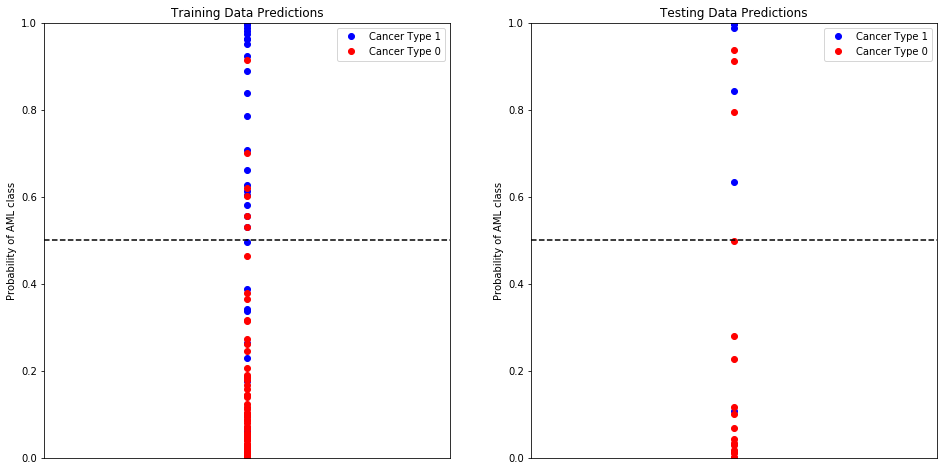

In [20]:
print("\nIt looks like Multiple Logistic Regression works a little better! Let's visuallize the estimations:\n")
def visualize_prob(model, x, y, ax):
    # Use the model to predict probabilities for
    y_pred = model.predict_proba(x)
    
    # Separate the predictions on the label 1 and label 0 points
    ypos = y_pred[y==1]
    yneg = y_pred[y==0]
    
    # Count the number of label 1 and label 0 points
    npos = ypos.shape[0]
    nneg = yneg.shape[0]
    
    # Plot the probabilities on a vertical line at x = 0, 
    # with the positive points in blue and negative points in red
    pos_handle = ax.plot(np.zeros((npos,1)), ypos[:,1], 'bo', label = 'Cancer Type 1')
    neg_handle = ax.plot(np.zeros((nneg,1)), yneg[:,1], 'ro', label = 'Cancer Type 0')

    # Line to mark prob 0.5
    ax.axhline(y = 0.5, color = 'k', linestyle = '--')
    
    # Add y-label and legend, do not display x-axis, set y-axis limit
    ax.set_ylabel('Probability of AML class')
    ax.legend(loc = 'best')
    ax.get_xaxis().set_visible(False)
    ax.set_ylim([0,1])
    
fig, (p1, p2) = plt.subplots(1, 2,figsize=(16,8))

visualize_prob(fitted_lr_all, X_train,y_train.values.ravel(), p1)
visualize_prob(fitted_lr_all, X_test,y_test.values.ravel(), p2)
p1.set_title("Training Data Predictions")
p2.set_title("Testing Data Predictions")

---
We have some great results, but we can do better! Let's employ every possible training modality we have exercised in CS109, and utilize grid_search_cv to find the best possible optimzation parameters.

---

In [21]:
# Creat array in which to save train and test results
# for best in class (bic) modeling
# columns:  model_name, train_score, test_score
bic_model_results = np.chararray((7,3),itemsize=30)
def run_best_in_class_model(model_text, model_class, model_parameters, X_train, y_train, X_test, y_test):

    '''
    This function uses GridSerachCV to tune parameters
    This function then fits a best-in-class model and prints accuracy scores.
    and prints accuracy score.
    model_text input:  displayed in results
    model:  model object that can be fit
    X_train: train data matrix
    y_train:  train response
    X_test:  test data matrix
    y_test:  test response
    '''
    
    # Define the GridSearchCV to find the best set of parameters
    model = GridSearchCV(model_class, model_parameters, cv=5)

    # Fit the model using GridSearchCV on training data
    model_fitted = model.fit(X_train,y_train)

    # Show which model was selected by GridSearchCV
    #print(model_fitted.best_estimator_)

    # Create prediction with model selected by GridSearchCV from test data
    y_train_hat = model_fitted.predict(X_train)
    y_test_hat = model_fitted.predict(X_test)

    # Create accuracy score with test data
    accuracy_score_train = accuracy_score(y_train,y_train_hat)
    accuracy_score_test = accuracy_score(y_test,y_test_hat)

    # Show results
    print('Base model: {:s}.\nTraining data accuracy score: {:0.3f}.'.format(model_text,accuracy_score_train))
    print('Testing data accuracy score: {:0.3f}.'.format(accuracy_score_test))
    print()
    
    return(accuracy_score_train, accuracy_score_test, model_fitted.best_estimator_)

In [22]:
# Create dictionary to save the best in class (bic) model objects for use in meta-model
optimized_model = pd.DataFrame(columns=["Model", "Training_Result", "Testing_Result", "Estimators"])

In [23]:
# Create best-in-class KNN model with GridSearchCV tuning
# Save model_text, training and test scores in array for plotting

models = [KNeighborsClassifier(), LogisticRegression(), LinearDiscriminantAnalysis(),
          QuadraticDiscriminantAnalysis(), DecisionTreeClassifier(),
          RandomForestClassifier(), AdaBoostClassifier()]

model_texts =['KNN', 'Logistic Regression', 'LDA', 'QDA',
              'Decision Tree Classifier', 'Random Forest Classifier', 'AdaBoost Classifier']

KNN_params = [{'n_neighbors': [1,3,5,10,15]}]
LOG_params = [{'C':[.0001,.0001,.001,.01,.1,1,10,100,1000,10000]}]
LDA_params = [{'solver':['lsqr'],'shrinkage':[0,.2,.4,.6,.8,1]}]
QDA_params = [{'reg_param': [.0001, .001, .01, .1, 1, 10, 100, 500, 1000, 10000]}]
DTC_params = [{'max_depth': [3,5],'max_features': [1,3,5],'min_samples_split': [2,4,8]}]
RFC_params = [{'n_estimators': [15,25,40], 'max_depth': [3,5,7,9],
               'max_features': [1,3,5], 'min_samples_split': [2,4,8]}]
ABC_params = [{'base_estimator':[LogisticRegression(), DecisionTreeClassifier(), RandomForestClassifier()],
               'learning_rate':[.2,.4,.6,.8]}]


model_params = [KNN_params, LOG_params, LDA_params, QDA_params, DTC_params, RFC_params, ABC_params]

for i, model in enumerate(models):
    bic_model_res = run_best_in_class_model(model_texts[i], model, model_params[i], \
                                        X_train, y_train, X_test, y_test)
    
    optimized_model = optimized_model.append({"Model":model_texts[i],
                                              "Training_Result":bic_model_res[0],
                                              "Testing_Result":bic_model_res[1],
                                              "Estimators":bic_model_res[2]}, ignore_index=True)
optimized_model

Base model: KNN.
Training data accuracy score: 1.000.
Testing data accuracy score: 0.806.

Base model: Logistic Regression.
Training data accuracy score: 0.867.
Testing data accuracy score: 0.806.

Base model: LDA.
Training data accuracy score: 0.767.
Testing data accuracy score: 0.710.

Base model: QDA.
Training data accuracy score: 0.767.
Testing data accuracy score: 0.742.

Base model: Decision Tree Classifier.
Training data accuracy score: 0.983.
Testing data accuracy score: 0.871.

Base model: Random Forest Classifier.
Training data accuracy score: 0.975.
Testing data accuracy score: 0.935.

Base model: AdaBoost Classifier.
Training data accuracy score: 1.000.
Testing data accuracy score: 0.903.



,Model,Training_Result,Testing_Result,Estimators
0,KNN,1.000000,0.806452,"KNeighborsClassifier(algorithm='auto', leaf_si..."
1,Logistic Regression,0.866667,0.806452,"LogisticRegression(C=10000, class_weight=None,..."
2,LDA,0.766667,0.709677,"LinearDiscriminantAnalysis(n_components=None, ..."
3,QDA,0.766667,0.741935,"QuadraticDiscriminantAnalysis(priors=None, reg..."
4,Decision Tree Classifier,0.983333,0.870968,"DecisionTreeClassifier(class_weight=None, crit..."
5,Random Forest Classifier,0.975000,0.935484,"(DecisionTreeClassifier(class_weight=None, cri..."
6,AdaBoost Classifier,1.000000,0.903226,"((DecisionTreeClassifier(class_weight=None, cr..."


---
These results achieve a maximum of 96% and 94% on the testing results (with AdaBoost and Random Forest, respectively), and a minimum of 74% and 67% (QDA, LDA respectively), which are still better results than flipping coins.

Unfortunately we cannot look at the Random Forest Classifier; we can only look at one tree. We'll take a look at the Random Forest parameters, but we'll also plot the decision tree classifier results too (which achieved a 90% accuracy with a max_depth of 9, but to limit the size of the picture I've set the max allowable depth to 5).

---

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=5, max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=4, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')


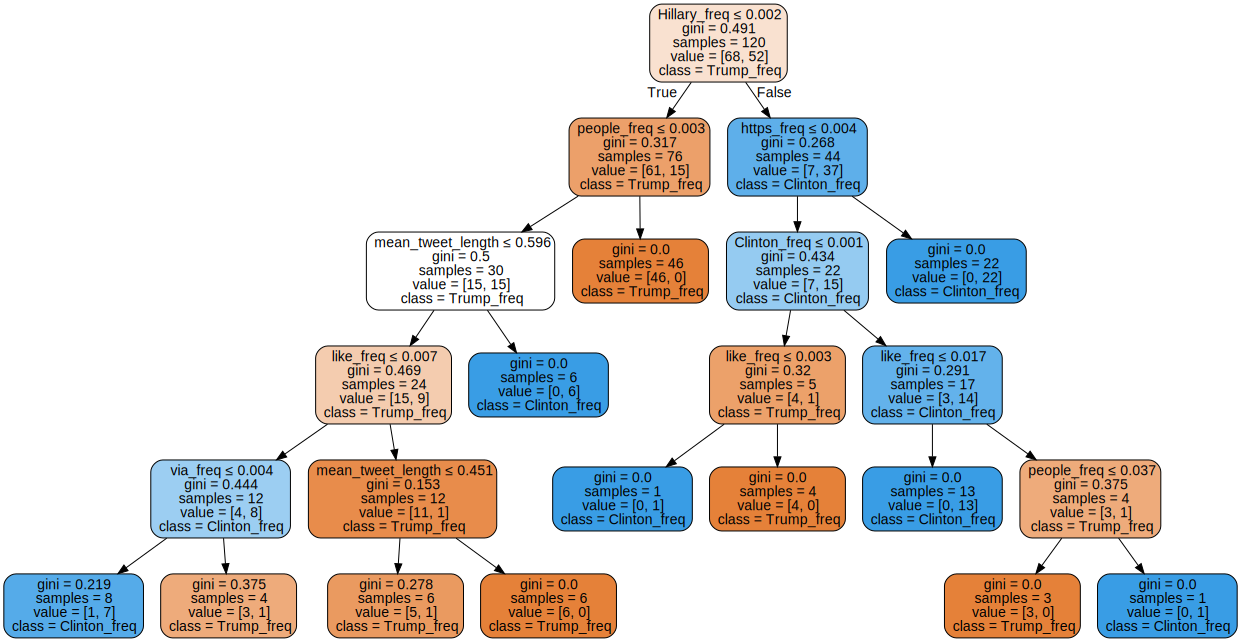

In [24]:
from sklearn import tree
import graphviz

print(optimized_model.loc[optimized_model['Model']=='Decision Tree Classifier']['Estimators'].values[0])
DT_model = optimized_model.loc[optimized_model['Model']=='Decision Tree Classifier']['Estimators'].values[0]
DT_fitted= DT_model.fit(X_train,y_train)

dot_data = tree.export_graphviz(DT_fitted, 
                         feature_names=cols,out_file=None,
                         class_names=cols,  
                         filled=True, rounded=True,  
                         special_characters=True)

graph = graphviz.Source(dot_data)  
graph 

---
There's a lot to talk about here, but to keep the analysis consice the top three variables shall be considered: the frequency at which people spoke about 
    1. Hilary,
    2. Used the word 'people', and
    3. Posted a link ('http').
    as a bonus
    4. The mean_tweet_length

The first three parameters can be traced to the result from [block 10] where it was observed that real people did not talk about Hilary Clinton, would frequently use the word 'people', and never posted links. These activities are inherently bot-like, as observed from our data. 

It is exciting to see that one of the originally engineered features, mean_tweet_length, was also selected as a top variable for this decision tree classifier.

---